# COSAS SUELTAS

Terminar el arbol  
Luego sacar el subproducto de importacia de variables  
Luego hacer random forest  
Optimizarlos con gridsearchCV  
Sacar metricas, curvas roc, curvas de validacion (train vs test en ajustes de gridsearch)  
Agregar funcion de ganancia y custom treshold  
Y luego seguir probando modelos, si agregamos knn o naive bayes creo que se necesita escalar las variables. (Escalar ayuda al arbol?)

In [ ]:
"""
PROBAR MUCHOS ARBOLES Y ENCONTRAR EL MEJOR


# Parámetros para optimizar en el GridSearchCV
param_grid = {
    'tree__max_depth': [5, 7, 10, 15],
    'tree__min_samples_split': [2, 5, 10, 12],
    'tree__min_samples_leaf': [1, 2, 4, 6],
    'tree__criterion': ['gini', 'entropy', 'log_loss'],
    'tree__max_features': ["sqrt", "log2", "auto", "None"],
    'tree__random_state': [42]
}

# Crear el GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline_arbol,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring=funcion_ganancia,
    n_jobs=-1,  # usa todos los cores disponibles
    verbose=2
)

# Entrenar
grid_search.fit(X_train, y_train)

# Mejores parámetros y score
print("Mejores parámetros:", grid_search.best_params_)
print("Mejor score:", grid_search.best_score_)

# Acceder al mejor modelo
best_pipeline = grid_search.best_estimator_
"""

In [ ]:
"""
# Evaluar el pipeline entrenado
metricas = evaluar_modelo(
    pipeline=best_pipeline,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    nombre_modelo="Árbol de Decisión"
)
"""

# Importaciones

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Agregamos modelos de ML
from sklearn.model_selection import train_test_split

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report


# Funciones Auxiliares

In [24]:
def evaluar_modelo(pipeline, X_train, X_test, y_train, y_test, nombre_modelo="Modelo"):
    """
    Evalúa un pipeline de clasificación y muestra métricas completas.
    
    Parámetros:
    -----------
    pipeline : sklearn.pipeline.Pipeline
        Pipeline entrenado a evaluar
    X_train : pd.DataFrame
        Datos de entrenamiento
    X_test : pd.DataFrame
        Datos de test
    y_train : pd.Series
        Target de entrenamiento
    y_test : pd.Series
        Target de test
    nombre_modelo : str, opcional
        Nombre del modelo para los títulos
    
    Retorna:
    --------
    dict : Diccionario con las métricas principales
    """
    from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, 
                                  classification_report, accuracy_score,
                                  precision_score, recall_score, f1_score)
    import matplotlib.pyplot as plt
    
    # Hacer predicciones
    y_pred_train = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)
    
    # Calcular métricas
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)
    precision = precision_score(y_test, y_pred_test, average='weighted')
    recall = recall_score(y_test, y_pred_test, average='weighted')
    f1 = f1_score(y_test, y_pred_test, average='weighted')
    
    # Imprimir resultados
    print("=" * 70)
    print(f"EVALUACIÓN: {nombre_modelo}")
    print("=" * 70)
    print(f"Accuracy en Train:        {acc_train:.4f}")
    print(f"Accuracy en Test:         {acc_test:.4f}")
    print(f"Diferencia (Overfitting): {acc_train - acc_test:.4f}")
    print(f"\nPrecision (weighted):     {precision:.4f}")
    print(f"Recall (weighted):        {recall:.4f}")
    print(f"F1-Score (weighted):      {f1:.4f}")
    
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred_test)
    print("\n" + "=" * 70)
    print("MATRIZ DE CONFUSIÓN - TEST SET")
    print("=" * 70)
    print(cm)
    
    # Visualizar la matriz de confusión
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    plt.title(f'Matriz de Confusión - {nombre_modelo} (Test Set)', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Reporte de clasificación
    print("\n" + "=" * 70)
    print("REPORTE DE CLASIFICACIÓN - TEST SET")
    print("=" * 70)
    print(classification_report(y_test, y_pred_test))
    
    # Información del modelo (si tiene)
    if hasattr(pipeline, 'named_steps'):
        # Buscar el clasificador en el pipeline
        for step_name, step in pipeline.named_steps.items():
            if hasattr(step, 'get_depth'):  # Es un árbol
                print("\n" + "=" * 70)
                print(f"PARÁMETROS DEL ÁRBOL ({step_name})")
                print("=" * 70)
                print(f"Max Depth (configurado): {step.max_depth}")
                print(f"Profundidad Real:        {step.get_depth()}")
                print(f"Número de Hojas:         {step.get_n_leaves()}")
                print(f"Número de Features:      {step.n_features_in_}")
            elif hasattr(step, 'n_estimators'):  # Es un Random Forest o similar
                print("\n" + "=" * 70)
                print(f"PARÁMETROS DEL ENSEMBLE ({step_name})")
                print("=" * 70)
                print(f"Número de estimadores:   {step.n_estimators}")
                print(f"Max Depth:               {step.max_depth}")
                print(f"Número de Features:      {step.n_features_in_}")
    
    # Retornar métricas en un diccionario
    return {
        'accuracy_train': acc_train,
        'accuracy_test': acc_test,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'overfitting': acc_train - acc_test,
        'confusion_matrix': cm
    }


In [101]:
def visualizar_arbol_importancia(pipeline, X_train, model_step_name='tree', 
                                  class_names=None, title='Árbol de Decisión',
                                  max_depth_plot=3, top_n_features=20, 
                                  top_n_print=15, figsize_tree=(20, 12), 
                                  figsize_importance=(12, 8)):
    """
    Visualiza un árbol de decisión y la importancia de las variables.
    
    Parámetros:
    -----------
    pipeline : Pipeline
        Pipeline de sklearn que contiene el modelo de árbol
    X_train : DataFrame
        Datos de entrenamiento
    model_step_name : str, default='tree'
        Nombre del paso del modelo en el pipeline
    class_names : list, optional
        Nombres de las clases para la visualización
    title : str, default='Árbol de Decisión'
        Título para los gráficos
    max_depth_plot : int, default=3
        Profundidad máxima del árbol a visualizar
    top_n_features : int, default=20
        Número de features a mostrar en el gráfico de importancia
    top_n_print : int, default=15
        Número de features a imprimir en la tabla
    figsize_tree : tuple, default=(20, 12)
        Tamaño de la figura del árbol
    figsize_importance : tuple, default=(12, 8)
        Tamaño de la figura de importancia
    """
    from sklearn.tree import plot_tree
    import matplotlib.pyplot as plt
    import pandas as pd
    
    # Extraer el modelo del pipeline
    model = pipeline.named_steps[model_step_name]
    
    # Obtener los nombres de las features después de las transformaciones
    X_transformed = pipeline[:-1].transform(X_train)
    feature_names = X_transformed.columns.tolist()
    
    # Visualizar el árbol
    plt.figure(figsize=figsize_tree)
    plot_tree(model, 
              fontsize=10, 
              filled=True, 
              feature_names=feature_names, 
              class_names=class_names,
              max_depth=max_depth_plot,
              impurity=True,
              proportion=True)
    plt.title(f'{title}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # ==== IMPORTANCIA DE VARIABLES ====
    print("\n" + "="*70)
    print("IMPORTANCIA DE LAS VARIABLES")
    print("="*70)
    
    # Obtener importancias
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # Mostrar top features
    print(f"\nTop {top_n_print} variables más importantes:")
    print(feature_importance_df.head(top_n_print).to_string(index=False))
    
    # Visualizar importancias
    plt.figure(figsize=figsize_importance)
    top_features = feature_importance_df.head(top_n_features)
    plt.barh(range(len(top_features)), top_features['Importance'])
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Importancia', fontsize=12)
    plt.ylabel('Variables', fontsize=12)
    plt.title(f'Top {top_n_features} Variables Más Importantes - {title}', 
              fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    return feature_importance_df

In [147]:
from sklearn.model_selection import validation_curve

def plot_validation_curve(estimator, X, y, param_name, param_range, cv=5, scoring='accuracy', n_jobs=-1):
    """
    Genera y muestra la curva de validación de un modelo.

    Parámetros:
    -----------
    estimator : estimador sklearn
        Modelo (o pipeline) a evaluar.
    X : pd.DataFrame o np.array
        Datos de entrada.
    y : pd.Series o np.array
        Target.
    param_name : str
        Nombre del hiperparámetro a variar (por ejemplo 'tree__max_depth').
    param_range : array-like
        Valores del hiperparámetro a evaluar.
    cv : int
        Número de folds en la validación cruzada.
    scoring : str
        Métrica para evaluar ('accuracy', 'roc_auc', etc.).
    n_jobs : int
        Cantidad de cores a usar.
    """
    train_scores, valid_scores = validation_curve(
        estimator, X, y, 
        param_name=param_name, 
        param_range=param_range, 
        cv=cv, 
        scoring=scoring, 
        n_jobs=n_jobs
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    valid_mean = np.mean(valid_scores, axis=1)
    valid_std = np.std(valid_scores, axis=1)

    plt.figure(figsize=(8,6))
    plt.plot(param_range, train_mean, label="Train score", color="blue", marker='o')
    plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")
    plt.plot(param_range, valid_mean, label="Validation score", color="green", marker='o')
    plt.fill_between(param_range, valid_mean - valid_std, valid_mean + valid_std, alpha=0.2, color="green")
    
    plt.title(f"Validation Curve for {param_name}")
    plt.xlabel(param_name)
    plt.ylabel(scoring)
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

# Lectura del Dataframe

In [19]:
columnas_numericas = ['surface_total', 'rooms', 'bathrooms']

In [8]:
df = pd.read_csv('datasets/dptos_entrenamiento.csv')
df.set_index('id', inplace=True)
df.head(2)

,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,l4,l5,l6,rooms,bedrooms,bathrooms,surface_total,surface_covered,price_period,title,paga_comision
id,,,,,,,,,,,,,,,,,,,,
RDfa+E7upD0n5pptEfHdMg==,Propiedad,2020-01-08,2020-01-11,2020-01-08,-37.999860,-57.555031,Argentina,Buenos Aires Costa Atlántica,Mar del Plata,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,Venta depto dos ambientes con frente abierto,no paga
mL0EoZeEqENVokwugUrtow==,Propiedad,2020-01-17,2020-01-21,2020-01-17,-34.566363,-58.438766,Argentina,Capital Federal,Palermo,NaN,NaN,NaN,4.0,3.0,1.0,81.0,75.0,NaN,VENTA 4 AMBIENTES C COCHERA FIJA MUY LUMINOSO,paga


# Split train y test

In [9]:
encoder = OrdinalEncoder()
df['paga_comision_encoded'] = encoder.fit_transform(df[['paga_comision']])

df.drop(columns=['paga_comision'], inplace=True)
df['paga_comision_encoded'].astype('int64')

id
RDfa+E7upD0n5pptEfHdMg==    0
mL0EoZeEqENVokwugUrtow==    1
hOZOY5Bo9FzB3IR8V6TtiA==    0
JKfw+/BUerJ7cNjors3UBQ==    0
SBDKF7R+J2C+n4gWm4JrOw==    0
                           ..
SJ10BUgrdEGcpN625rUnvQ==    0
QRvbcLYpdFrsjDoarhQRxQ==    0
149re/PCUyrmtsbpa2SAOg==    0
W6mebjf8pbvzxLhmhLYiCQ==    0
5UlIUMHlRN2N2ChpjTMy6g==    0
Name: paga_comision_encoded, Length: 76984, dtype: int64

In [10]:
# Split 70-30
X = df.drop(columns="paga_comision_encoded")
y = df["paga_comision_encoded"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state=54)

# Preprocesamiento y prueba de modelos

# Función de Ganancia y Probabilidad de Corte


Universo Total = paga_comision('paga') + paga_comision('no_paga')  
ganancia = **100** * paga_comision('paga') - **50** * paga_comision('no_paga')  
ganancia = **150** * paga_comision('paga') - **50** * paga_comision('paga') - **50** * paga_comision('no_paga')  

150 * paga_comision('paga') - 50 * paga_comision('paga') - 50 * paga_comision('no_paga') > 0

150 * paga_comision('paga') - 50 * (paga_comision('paga') + paga_comision('no_paga')) > 0

150 * paga_comision('paga') > 50 * (paga_comision('paga') + paga_comision('no_paga'))

paga_comision('paga') > (50/150) * (paga_comision('paga') + paga_comision('no_paga'))

paga_comision('paga') / (paga_comision('paga') + paga_comision('no_paga')) > 50/150

Prob('paga') > 0.33

In [48]:
def funcion_ganancia(clf, X, y_true):
    prob_corte = 0.33
    y_prob_pago = clf.predict_proba(X)[:, 1]
    
    ganancias = []
    for i in range(len(y_prob_pago)):
        if y_prob_pago[i] > prob_corte:
            if y_true.iloc[i] > 0:  # ← corrección aquí
                ganancias.append(100)
            else:
                ganancias.append(-50)
    
    ganancia = sum(ganancias)
    return ganancia

# Transformaciones

## Enconding

In [12]:
# Pasé las transformaciones a un diccionario para hacerlas reusables.
ddtr_enc = {}
ddtr_enc["ct_oh_l1"] = ("oh_l1", OneHotEncoder(sparse_output=False, dtype=int, drop='first'), ["l1"])
ddtr_enc["ct_oh_l2"] = ("oh_l2", OneHotEncoder(sparse_output=False, dtype=int, drop='first'), ["l2"])


ct_enc = ColumnTransformer([ddtr_enc["ct_oh_l1"], 
                        ddtr_enc["ct_oh_l2"]])

In [50]:
class ColOneHot(BaseEstimator, TransformerMixin):
    def __init__(self, encoder=None, columns=None):
        super().__init__()
        self.encoder = encoder or OneHotEncoder(handle_unknown="ignore", sparse_output=False)
        self.columns = columns or []
        
    def fit(self, X, y=None):
        self.encoder.fit(X[self.columns])
        return self    
    
    def get_feature_names_out(self):
        return self.encoder.get_feature_names_out(self.columns)
    
    def transform(self, X):
        Xc = X.copy()
        # Aplicar one-hot y convertir a DataFrame
        encoded = self.encoder.transform(Xc[self.columns])
        encoded_df = pd.DataFrame(
            encoded,
            columns=self.get_feature_names_out(),
            index=Xc.index
        )
        # Reemplazar las columnas originales por las codificadas
        Xc.drop(self.columns, axis=1, inplace=True)
        Xc = pd.concat([Xc, encoded_df], axis=1)
        return Xc

## Outliers

In [15]:
class OutlierHandler(BaseEstimator, TransformerMixin):
    """
    Transformer personalizado para manejar outliers.
    Detecta outliers usando el método IQR y los convierte en NaN.
    
    Parámetros:
    -----------
    columns : list, default=None
        Lista de columnas a procesar. Si es None, procesa todas las columnas.
    factor : float, default=1.5
        Factor multiplicador del IQR para definir los límites.
        - 1.5: detección estándar (más conservador)
        - 3.0: detección extrema (solo outliers muy alejados)
    
    Ejemplo:
    --------
    >>> # Solo procesar columnas específicas
    >>> outlier_handler = OutlierHandler(columns=['lat', 'lon'], factor=1.5)
    >>> X_transformed = outlier_handler.fit_transform(X_train)
    """
    
    def __init__(self, columns=None, factor=1.5):
        self.columns = columns
        self.factor = factor
        self.lower_bounds = {}
        self.upper_bounds = {}
        self.outlier_counts = {}
        self.columns_ = None  # Columnas que realmente se procesarán
        
    def fit(self, X, y=None):
        """
        Calcula los límites inferior y superior para cada columna.
        
        Parámetros:
        -----------
        X : pd.DataFrame o np.ndarray
            DataFrame con variables numéricas.
        y : array-like, opcional
            Target (no se usa, solo por compatibilidad sklearn).
        """
        # Convertir a DataFrame si es necesario
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        
        # Determinar qué columnas procesar
        if self.columns is None:
            # Si no se especifican, usar todas las columnas
            self.columns_ = X.columns.tolist()
        else:
            # Validar que las columnas existen
            missing_cols = set(self.columns) - set(X.columns)
            if missing_cols:
                raise ValueError(f"Columnas no encontradas: {missing_cols}")
            self.columns_ = self.columns
        
        # Calcular límites IQR para cada columna especificada
        for col in self.columns_:
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1
            
            self.lower_bounds[col] = Q1 - self.factor * IQR
            self.upper_bounds[col] = Q3 + self.factor * IQR
            
            # Contar outliers para estadísticas
            outliers = ((X[col] < self.lower_bounds[col]) | 
                       (X[col] > self.upper_bounds[col]))
            self.outlier_counts[col] = outliers.sum()
        
        return self
    
    def transform(self, X):
        """
        Convierte outliers en NaN para posterior imputación.
        
        Parámetros:
        -----------
        X : pd.DataFrame o np.ndarray
            DataFrame con variables numéricas.
            
        Retorna:
        --------
        X_copy : pd.DataFrame o np.ndarray
            DataFrame con outliers convertidos a NaN.
        """
        # Convertir a DataFrame si es necesario
        is_dataframe = isinstance(X, pd.DataFrame)
        if not is_dataframe:
            X = pd.DataFrame(X)
        
        X_copy = X.copy()
        
        # Solo procesar las columnas especificadas
        for col in self.columns_:
            if col in X_copy.columns:
                # Detectar outliers (fuera de límites IQR)
                outlier_mask = (
                    (X_copy[col] < self.lower_bounds[col]) | 
                    (X_copy[col] > self.upper_bounds[col])
                )
                
                # Convertir outliers a NaN
                X_copy.loc[outlier_mask, col] = np.nan
        
        # Retornar en el mismo formato que la entrada
        return X_copy if is_dataframe else X_copy.values
    
    def get_feature_names_out(self, input_features=None):
        """
        Obtener nombres de las features de salida.
        Necesario para compatibilidad con ColumnTransformer.
        """
        if input_features is None:
            return np.array(self.columns_)
        return np.array(input_features)

## Imputaciones

In [16]:
class ColumnImputer(BaseEstimator, TransformerMixin):
    def __init__(self, imputer=SimpleImputer(strategy="mean"), columns=None):
        self.imputer = imputer
        self.columns = columns

    def fit(self, X, y=None):
        # Guardar todos los nombres de columnas del DataFrame original
        self.feature_names_in_ = X.columns.tolist()
        self.imputer.fit(X[self.columns])
        return self
    
    def get_feature_names_out(self, input_features=None):
        """Devuelve todos los nombres de columnas del DataFrame original"""
        return np.array(self.feature_names_in_)
    
    def transform(self, X):
        Xc = X.copy()
        # Esto mantiene los nombres de columnas porque asignamos al DataFrame
        Xc.loc[:, self.columns] = self.imputer.transform(X[self.columns])
        return Xc

## Eliminación de columnas

In [17]:
class ColumnDropper(BaseEstimator, TransformerMixin):
    """
    Transformer para eliminar columnas específicas de un DataFrame.
    
    Parámetros:
    -----------
    columns : list
        Lista de nombres de columnas a eliminar.
    
    Ejemplo:
    --------
    >>> dropper = ColumnDropper(columns=['col1', 'col2'])
    >>> X_transformed = dropper.fit_transform(X)
    """
    
    def __init__(self, columns):
        self.columns = columns
        self.feature_names_out_ = None  # Columnas que quedan después de eliminar

    def fit(self, X, y=None):
        """
        Calcula qué columnas quedarán después de eliminar.
        
        Parámetros:
        -----------
        X : pd.DataFrame
            DataFrame de entrada.
        y : array-like, opcional
            Target (no se usa, solo por compatibilidad sklearn).
        """
        # Validar que X es DataFrame
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X debe ser un pandas DataFrame")
        
        # Validar que las columnas a eliminar existen
        missing_cols = set(self.columns) - set(X.columns)
        if missing_cols:
            raise ValueError(f"Columnas no encontradas: {missing_cols}")
        
        # Guardar las columnas que quedarán después de eliminar
        self.feature_names_out_ = [col for col in X.columns if col not in self.columns]
        
        return self   
     
    def get_feature_names_out(self, input_features=None):
        """
        Obtiene los nombres de las features después de la transformación.
        
        Parámetros:
        -----------
        input_features : array-like, opcional
            Nombres de las features de entrada. Si es None, usa las guardadas en fit.
            
        Retorna:
        --------
        feature_names : np.ndarray
            Array con los nombres de las columnas después de eliminar.
        """
        if input_features is None:
            # Usar las columnas guardadas durante fit
            if self.feature_names_out_ is None:
                raise ValueError("Debe llamar a fit() antes de get_feature_names_out()")
            return np.array(self.feature_names_out_)
        else:
            # Filtrar las columnas de input_features
            return np.array([col for col in input_features if col not in self.columns])
    
    def transform(self, X):
        """
        Elimina las columnas especificadas.
        
        Parámetros:
        -----------
        X : pd.DataFrame
            DataFrame de entrada.
            
        Retorna:
        --------
        Xc : pd.DataFrame
            DataFrame sin las columnas eliminadas.
        """
        # Validar que se hizo fit
        if self.feature_names_out_ is None:
            raise ValueError("Debe llamar a fit() antes de transform()")
        
        # Crear copia y eliminar columnas
        Xc = X.copy()
        cols_to_drop = [col for col in self.columns if col in Xc.columns]
        Xc.drop(cols_to_drop, axis=1, inplace=True)
        
        return Xc

## Generacion de Columnas

In [84]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np

class L2AverageAdder(BaseEstimator, TransformerMixin):
    """
    Transformer que agrega una columna 'l2_average' con el promedio de 'surface_covered' 
    por cada valor de la columna 'l2'.

    Parámetros
    ----------
    l2_col : str
        Nombre de la columna categórica (por ejemplo, 'l2').
    target_col : str
        Nombre de la columna numérica sobre la que se calculará el promedio (por ejemplo, 'surface_covered').

    Ejemplo
    --------
    >>> avg_adder = L2AverageAdder(l2_col='l2', target_col='surface_covered')
    >>> X_transformed = avg_adder.fit_transform(X)
    """

    def __init__(self, l2_col='l2', target_col='surface_covered'):
        self.l2_col = l2_col
        self.target_col = target_col
        self.l2_means_ = None
        self.feature_names_out_ = None

    def fit(self, X, y=None):
        """
        Calcula el promedio de target_col por cada categoría de l2_col.
        """
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X debe ser un pandas DataFrame")
        
        if self.l2_col not in X.columns or self.target_col not in X.columns:
            raise ValueError(f"Las columnas '{self.l2_col}' y '{self.target_col}' deben existir en X")
        
        # Calcular promedio por provincia (o valor de l2)
        self.l2_means_ = X.groupby(self.l2_col)[self.target_col].mean().to_dict()

        # Guardar nombres de columnas resultantes
        self.feature_names_out_ = list(X.columns) + ['l2_average']
        return self

    def transform(self, X):
        """
        Agrega la columna 'l2_average' con el promedio correspondiente según el valor de 'l2'.
        """
        if self.l2_means_ is None:
            raise ValueError("Debe llamar a fit() antes de transform()")
        
        Xc = X.copy()

        # Mapear promedio según el valor de l2
        Xc['l2_average'] = Xc[self.l2_col].map(self.l2_means_)

        # Si hay valores de l2 que no estaban en el fit, asignar NaN
        Xc['l2_average'] = Xc['l2_average'].fillna(np.nan)

        return Xc


    def get_feature_names_out(self, input_features=None):
        """
        Devuelve los nombres de las columnas después de la transformación.
        """
        if self.feature_names_out_ is None:
            raise ValueError("Debe llamar a fit() antes de get_feature_names_out()")
        return np.array(self.feature_names_out_)


In [120]:
class PricePeriodNullFlag(BaseEstimator, TransformerMixin):
    """
    Transformer que agrega la columna 'is_price_period_null' indicando si 'price_period' es nula.
    
    Ejemplo:
    --------
    >>> flagger = PricePeriodNullFlag(column='price_period')
    >>> X_transformed = flagger.fit_transform(X)
    """
    def __init__(self, column='price_period'):
        self.column = column
        self.feature_names_out_ = None

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X debe ser un pandas DataFrame")
        if self.column not in X.columns:
            raise ValueError(f"La columna '{self.column}' no existe en X")
        
        # Guardar nombres de columnas resultantes
        self.feature_names_out_ = list(X.columns) + [f'is_{self.column}_null']
        return self

    def transform(self, X):
        if self.feature_names_out_ is None:
            raise ValueError("Debe llamar a fit() antes de transform()")
        
        Xc = X.copy()
        Xc[f'is_{self.column}_null'] = Xc[self.column].isnull()
        
        return Xc

    def get_feature_names_out(self, input_features=None):
        if self.feature_names_out_ is None:
            raise ValueError("Debe llamar a fit() antes de get_feature_names_out()")
        return np.array(self.feature_names_out_)

## Pipeline Arbol inicial

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

pipeline_arbol = Pipeline(
    steps=[
        ("outliers", OutlierHandler(columns=columnas_numericas, factor=1.5)),
        ("l2_avg", L2AverageAdder(l2_col="l2", target_col="surface_covered")),
        ("dropper_preKNN", ColumnDropper(columns=["lat", "lon", "ad_type", "start_date", "end_date", "created_on", "price_period", "title", "l1", "l2", "l3", "l4", "l5", "l6"])),
        ("imputer", ColumnImputer(imputer=SimpleImputer(strategy="mean"), columns=["rooms", "surface_total", "bathrooms", "bedrooms", "surface_covered"])),
        ("tree", DecisionTreeClassifier(
            max_depth=10,              # Profundidad máxima
            min_samples_split=20,      # Mínimo de muestras para dividir
            min_samples_leaf=5,        # Mínimo de muestras en hoja
            criterion='gini',          # Criterio de división
            max_features='sqrt',       # Número de features a considerar
            random_state=42
        ))
    ])


In [153]:
pipeline_arbol.fit(X_train, y_train)


,steps,"[('outliers', ...), ('dropper_preKNN', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,columns,"['surface_total', 'rooms', ...]"
,factor,1.5
,columns,"['lat', 'lon', ...]"
,imputer,SimpleImputer()
,columns,"['rooms', 'surface_total', ...]"
,missing_values,nan
,strategy,'mean'


EVALUACIÓN: Árbol de Decisión
Accuracy en Train:        0.9372
Accuracy en Test:         0.9299
Diferencia (Overfitting): 0.0073

Precision (weighted):     0.9250
Recall (weighted):        0.9299
F1-Score (weighted):      0.9263

MATRIZ DE CONFUSIÓN - TEST SET
[[19926   538]
 [ 1082  1550]]


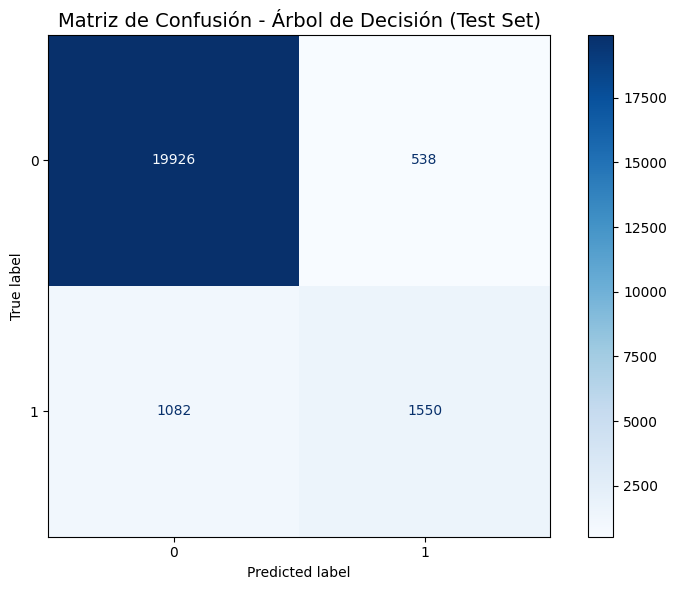


REPORTE DE CLASIFICACIÓN - TEST SET
              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96     20464
         1.0       0.74      0.59      0.66      2632

    accuracy                           0.93     23096
   macro avg       0.85      0.78      0.81     23096
weighted avg       0.93      0.93      0.93     23096


PARÁMETROS DEL ÁRBOL (tree)
Max Depth (configurado): 10
Profundidad Real:        10
Número de Hojas:         335
Número de Features:      5


In [154]:
# Evaluar el pipeline entrenado
metricas = evaluar_modelo(
    pipeline=pipeline_arbol,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    nombre_modelo="Árbol de Decisión"
)


In [155]:
# ===== CALCULAR GANANCIA EN TRAIN =====
ganancia_train = funcion_ganancia(pipeline_arbol, X_train, y_train)
print(f"Ganancia en Train: ${ganancia_train:,.0f}")

# ===== CALCULAR GANANCIA EN TEST =====
ganancia_test = funcion_ganancia(pipeline_arbol, X_test, y_test)
print(f"Ganancia en Test: ${ganancia_test:,.0f}")

# ===== CALCULAR GANANCIA POR OBSERVACIÓN =====
ganancia_promedio_test = ganancia_test / len(y_test)
print(f"Ganancia promedio por observación: ${ganancia_promedio_test:.2f}")

Ganancia en Train: $352,400
Ganancia en Test: $135,250
Ganancia promedio por observación: $5.86


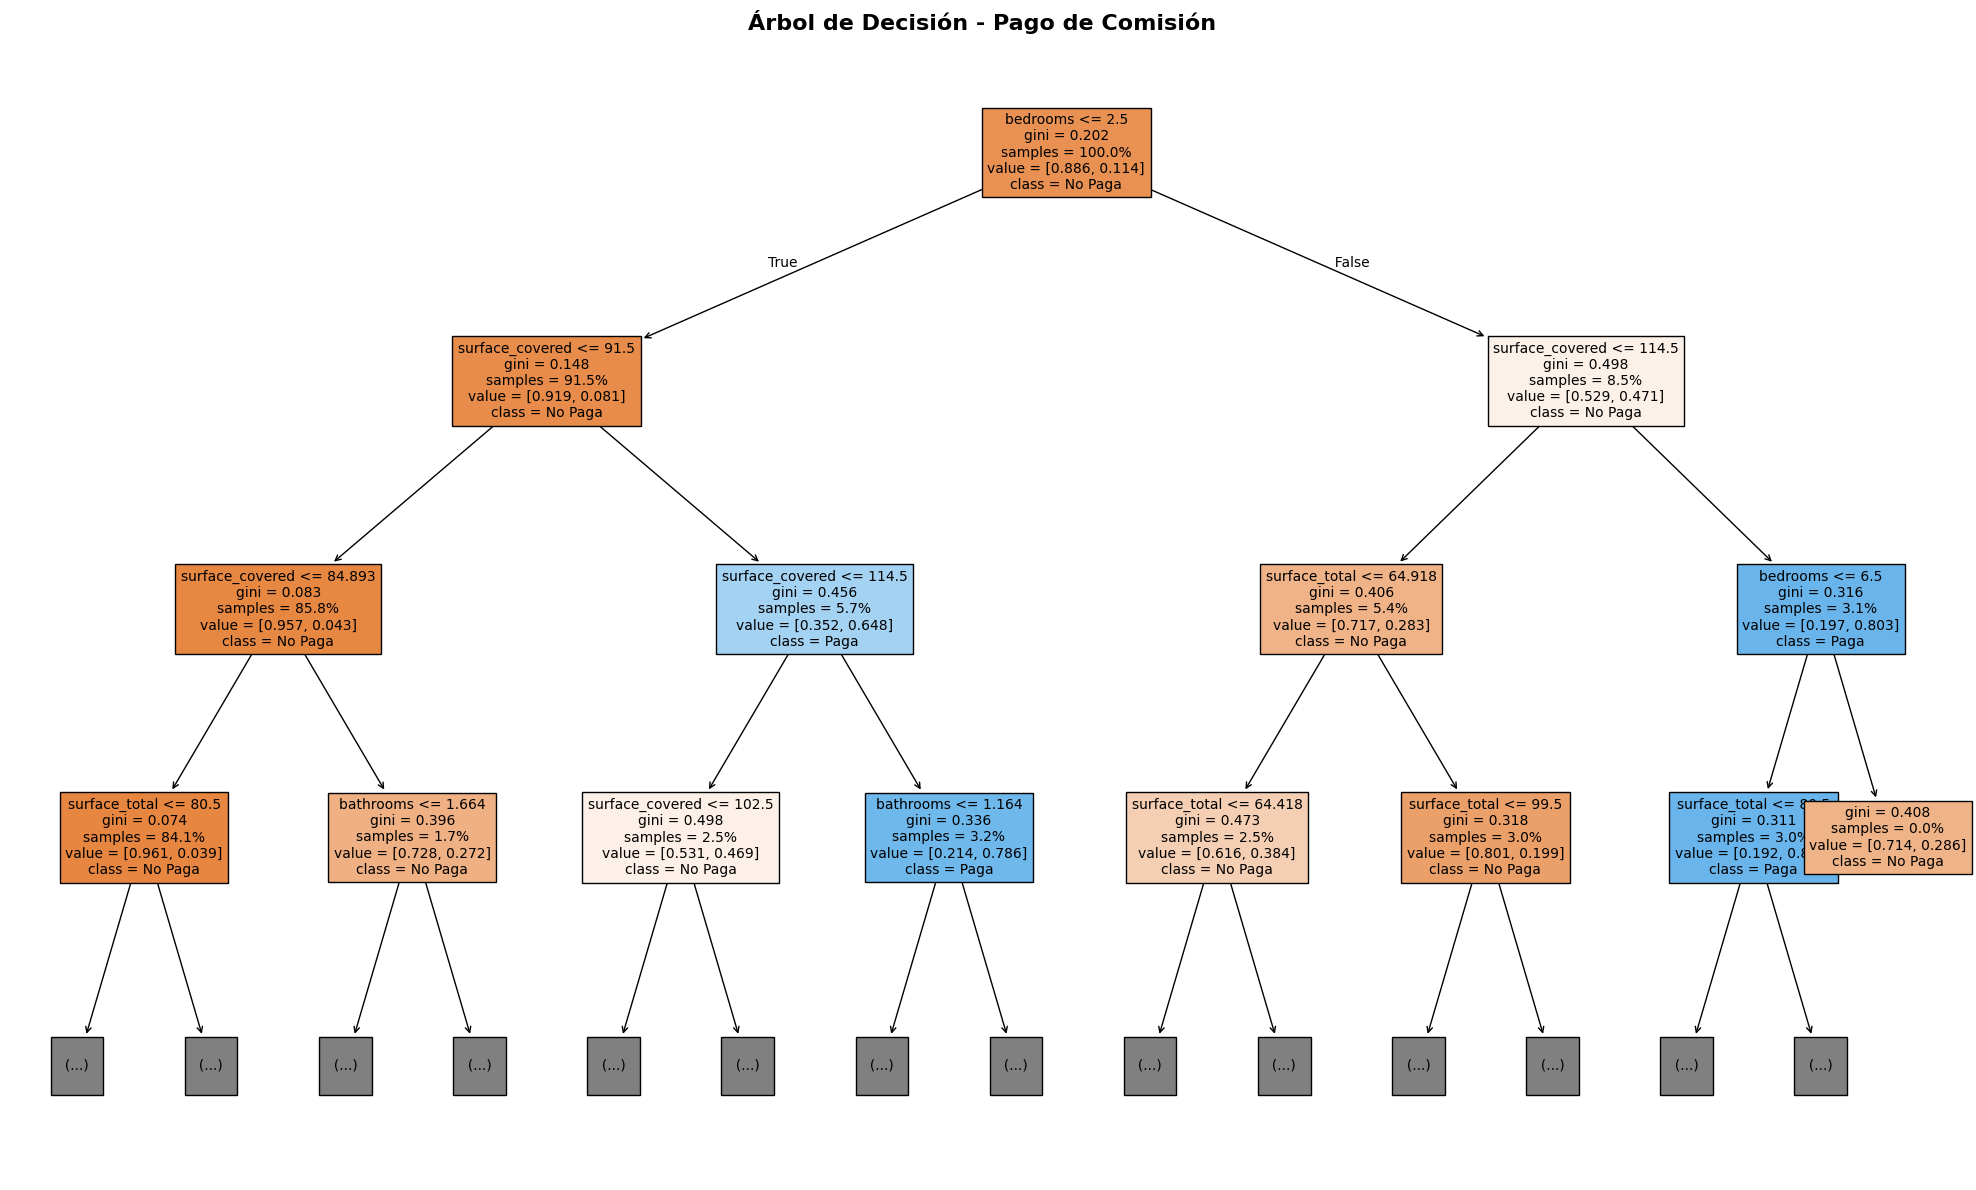


IMPORTANCIA DE LAS VARIABLES

Top 15 variables más importantes:
        Feature  Importance
surface_covered    0.551675
       bedrooms    0.234654
      bathrooms    0.111649
  surface_total    0.081764
          rooms    0.020258


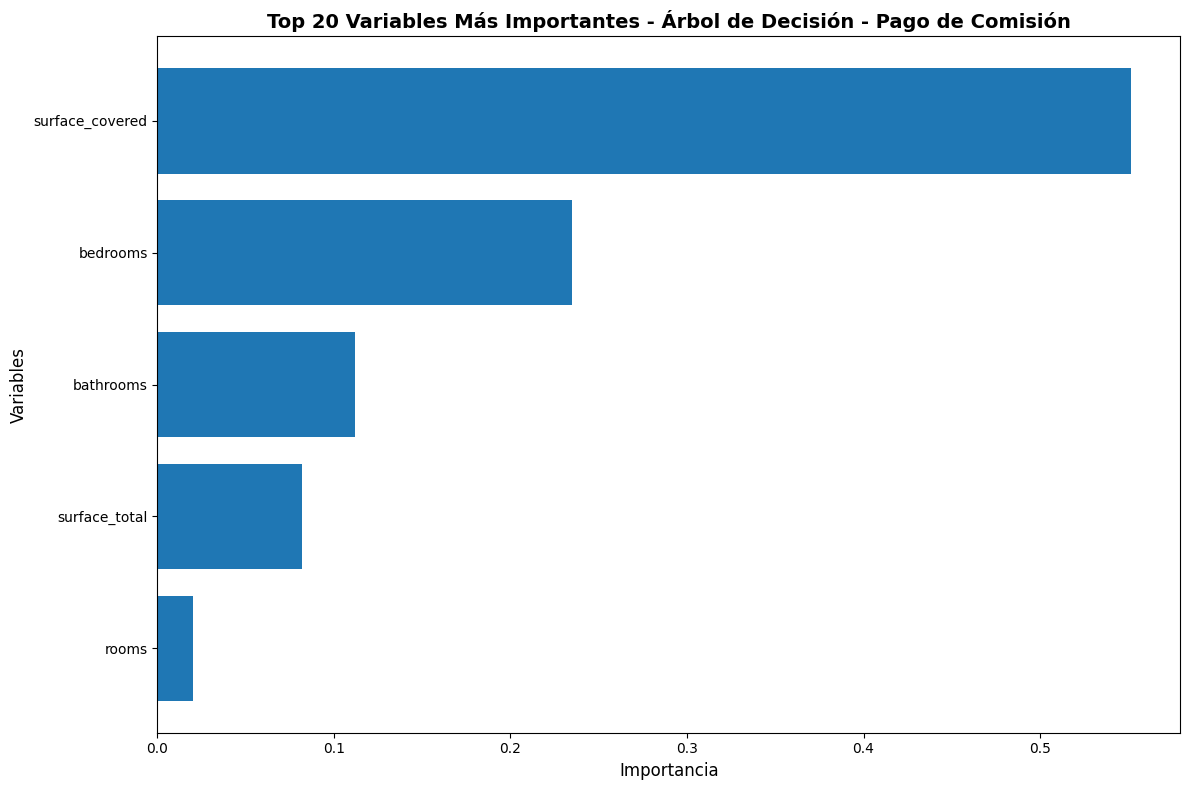

,Feature,Importance
4,surface_covered,0.551675
1,bedrooms,0.234654
2,bathrooms,0.111649
3,surface_total,0.081764
0,rooms,0.020258


In [156]:
visualizar_arbol_importancia(
    pipeline=pipeline_arbol,
    X_train=X_train,
    model_step_name='tree',
    class_names=['No Paga', 'Paga'],
    title='Árbol de Decisión - Pago de Comisión',
    max_depth_plot=3,
    top_n_features=20,
    top_n_print=15
)

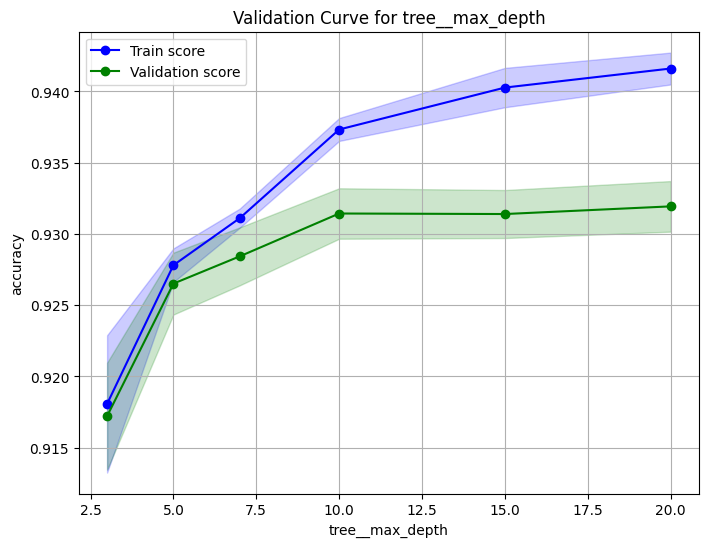

In [157]:
## CURVA DE VALIDACION
param_range = [3, 5, 7, 10, 15, 20]
plot_validation_curve(
    estimator=pipeline_arbol,
    X=X_train,
    y=y_train,
    param_name='tree__max_depth',  # pipe_step__hyperparam
    param_range=param_range,
    cv=5,
    scoring='accuracy'
)

# Random Forest


In [140]:
from sklearn.ensemble import RandomForestClassifier

In [141]:
pipeline_forest = Pipeline(
    steps=[
        ("outliers", OutlierHandler(columns=columnas_numericas, factor=2.25)),
        ("l2_avg", L2AverageAdder(l2_col="l2", target_col="surface_covered")),
        ("dropper_preKNN", ColumnDropper(columns=["lat", "lon", "ad_type", "start_date", "end_date", "created_on", "price_period", "title", "l1","l2", "l3", "l4", "l5", "l6"])),
        ("imputer", ColumnImputer(imputer=SimpleImputer(strategy="mean"), columns=["rooms", "surface_total", "bathrooms", "bedrooms", "surface_covered"])),
        ("forest", RandomForestClassifier())
    ])

In [142]:
pipeline_forest.fit(X_train, y_train)


,steps,"[('outliers', ...), ('l2_avg', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,columns,"['surface_total', 'rooms', ...]"
,factor,2.25
,l2_col,'l2'
,target_col,'surface_covered'
,columns,"['lat', 'lon', ...]"
,imputer,SimpleImputer()
,columns,"['rooms', 'surface_total', ...]"


In [143]:
# ===== CALCULAR GANANCIA EN TEST =====
ganancia_test = funcion_ganancia(pipeline_forest, X_test, y_test)
print(f"Ganancia en Test: ${ganancia_test:,.0f}")

Ganancia en Test: $158,000


In [144]:
#Predicciones con la probabilidad de corte
y_pred = (pipeline_forest.predict_proba(X_test)[:, 1] > 0.33)

In [145]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.96      0.96     20464
         1.0       0.70      0.76      0.73      2632

    accuracy                           0.94     23096
   macro avg       0.83      0.86      0.85     23096
weighted avg       0.94      0.94      0.94     23096



### Random Forest con optimización de hiperparámetros

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

best_score = 0
param_grid = {
    'forest__criterion': ['gini', 'entropy', 'log_loss'],  # ⬅️ 'forest' es el nombre del paso
    'forest__max_depth': [3,4,6,8],
    'forest__min_samples_split': [2 ,4, 8, 10, 12],
    'forest__min_samples_leaf': [1, 2, 4, 6],
    'forest__max_features': ["sqrt"],
    'forest__n_estimators': [30,60,90,120,150,180]
}


# Crear el RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipeline_forest,
    param_distributions=param_grid,
    n_iter=1, # Número de combinaciones aleatorias a probar
    cv=4,
    scoring=funcion_ganancia,
    n_jobs=-1,
    verbose=2,
    random_state=42  # Opcional: para reproducibilidad
)

# Entrenar
random_search.fit(X_train, y_train)

# Mejores parámetros y score
print("Mejores parámetros:", random_search.best_params_)
print("Mejor score:", random_search.best_score_)

# Hacer predicciones con el mejor modelo
y_pred = random_search.predict(X_test)

# Acceder al mejor modelo
best_pipeline = random_search.best_estimator_

Fitting 4 folds for each of 1 candidates, totalling 4 fits
Mejores parámetros: {'forest__n_estimators': 150, 'forest__min_samples_split': 8, 'forest__min_samples_leaf': 2, 'forest__max_features': 'sqrt', 'forest__max_depth': 4, 'forest__criterion': 'log_loss'}
Mejor score: 81962.5


In [75]:
# ===== CALCULAR GANANCIA EN TEST =====
ganancia_test = funcion_ganancia(best_pipeline, X_test, y_test)
print(f"Ganancia en Test con RandomSearch: ${ganancia_test:,.0f}")

Ganancia en Test con RandomSearch: $132,750


In [76]:
#Predicciones con la probabilidad de corte
y_pred = (best_pipeline.predict_proba(X_test)[:, 1] > 0.33)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96     20464
         1.0       0.67      0.67      0.67      2632

    accuracy                           0.92     23096
   macro avg       0.81      0.81      0.81     23096
weighted avg       0.92      0.92      0.92     23096

